# Import Dependencies

## 1. Unzip the dataset

In [1]:
import glob
import zipfile
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import joblib
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### \# for this cell, only excecute once

In [2]:
# files = glob.glob('*.zip')
# files

In [3]:
# for file in files:
#     print('Unzipping:',file)

#     with zipfile.ZipFile(file, 'r') as zip_ref:
#         zip_ref.extractall('data/raw')

## 2. Split the dataset

In [4]:
aerobic_steppers    = glob.glob('data/raw/gym_data/aerobic_steppers/*.*')
dumb_bell           = glob.glob('data/raw/gym_data/dumb_bell/*.*')
treadmill           = glob.glob('data/raw/gym_data/treadmill/*.*')

In [5]:
data = []
labels = []

In [6]:
for i in aerobic_steppers:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(0)

for i in dumb_bell:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(1)

for i in treadmill:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(2)

In [7]:
data = np.array(data)
# data = data/255.
labels = np.array(labels)

In [8]:
data[0].shape

(224, 224, 3)

In [9]:
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

# Create model architecture

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [12]:
base_model.trainable = False
train_ds = preprocess_input(X_train)
test_ds = preprocess_input(X_test)

In [13]:
flatten_layer = Flatten()
dense_layer_1 = Dense(50, activation='relu')
dense_layer_2 = Dense(20, activation="relu")
prediction_layer = Dense(3, activation="softmax")

In [14]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [16]:
model = Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [17]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
#train the model
history = model.fit(X_train, ytrain, validation_data=(X_test, ytest), epochs=20)

Epoch 1/20
18/18 [==============================] - 57s 3s/step - loss: 0.7728 - accuracy: 0.7201 - val_loss: 0.2549 - val_accuracy: 0.9510
Epoch 2/20
18/18 [==============================] - 44s 2s/step - loss: 0.1649 - accuracy: 0.9507 - val_loss: 0.1604 - val_accuracy: 0.9510
Epoch 3/20
18/18 [==============================] - 46s 3s/step - loss: 0.1002 - accuracy: 0.9665 - val_loss: 0.1437 - val_accuracy: 0.9510
Epoch 4/20
18/18 [==============================] - 48s 3s/step - loss: 0.0609 - accuracy: 0.9806 - val_loss: 0.1093 - val_accuracy: 0.9580
Epoch 5/20
18/18 [==============================] - 50s 3s/step - loss: 0.0540 - accuracy: 0.9842 - val_loss: 0.1135 - val_accuracy: 0.9580
Epoch 6/20
18/18 [==============================] - 50s 3s/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.1752 - val_accuracy: 0.9510
Epoch 7/20
18/18 [==============================] - 50s 3s/step - loss: 0.0430 - accuracy: 0.9912 - val_loss: 0.1653 - val_accuracy: 0.9510
Epoch 8/20
18/18 [==

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


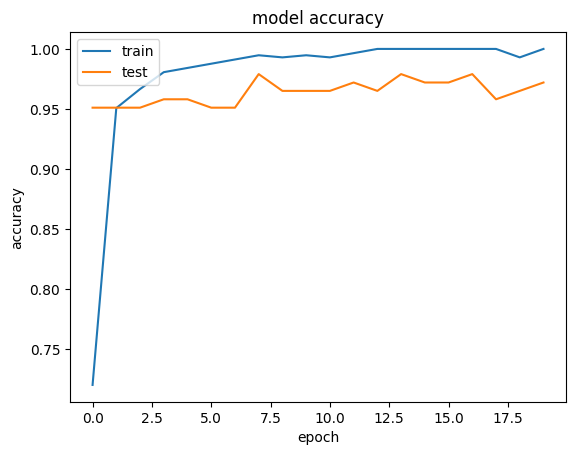

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

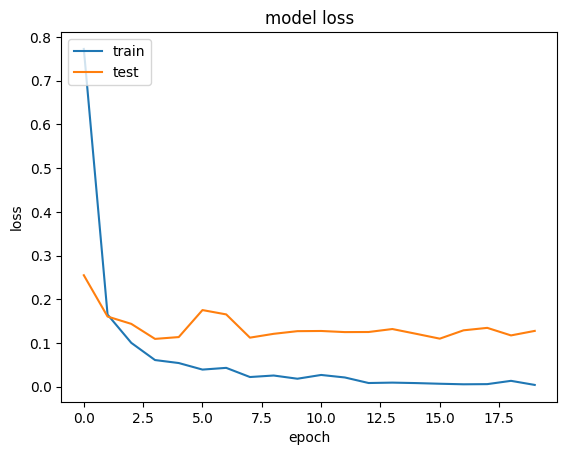

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.save('finalModel1.h5')

In [23]:
model = tf.keras.models.load_model('finalModel1.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\62822\AppData\Local\Temp\tmpy6fh515a\assets


INFO:tensorflow:Assets written to: C:\Users\62822\AppData\Local\Temp\tmpy6fh515a\assets


16049120

In [25]:
model = tf.keras.models.load_model('finalModel1.h5')

In [26]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 3)                